# Naural Networks

## Załadowanie i przygotowanie danych

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Wstępne załadowanie i eskploracja oryginalnych danych.

In [69]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:9999, :]
chess.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Zakodowanie godzin na dane z zakresu (0, 1)

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [70]:
hoursAfterMidnight = (chess.loc[:, 'created_at']/1000).apply(datetime.fromtimestamp).dt.hour
chess['sin_created_at'] = np.sin(2*np.pi*hoursAfterMidnight/24)
chess['cos_created_at'] = np.cos(2*np.pi*hoursAfterMidnight/24)

In [71]:
hoursAfterMidnight

0       22
1       23
2       23
3       18
4       20
        ..
9995    14
9996    12
9997    10
9998    10
9999     9
Name: created_at, Length: 10000, dtype: int64

Usunięcie niepotrzebnych kolumn.

In [72]:
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'moves', 'black_id', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply,sin_created_at,cos_created_at
0,False,13,white,15+2,1500,1191,D10,5,-0.500000,8.660254e-01
1,True,16,black,5+10,1322,1261,B00,4,-0.258819,9.659258e-01
2,True,61,white,5+10,1496,1500,C20,3,-0.258819,9.659258e-01
3,True,61,white,20+0,1439,1454,D02,3,-1.000000,-1.836970e-16
4,True,95,white,30+3,1523,1469,C41,5,-0.866025,5.000000e-01


Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

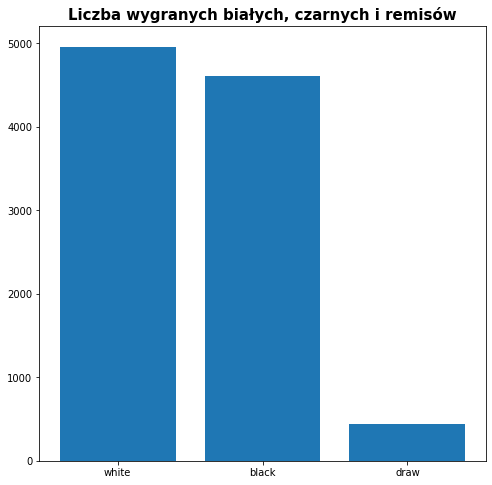

In [5]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Zamiana kolumny rated z Boolen na zero-jedynkową i zakodowanie wartości kategorycznych

In [73]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1
temp = pd.get_dummies(chess.loc[:, ['increment_code', 'winner', 'opening_eco']])
chess.drop(columns=['increment_code', 'winner', 'opening_eco'], inplace=True)
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-5.000000e-01,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000e+00,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-8.660254e-01,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,63,1195,1369,5,-5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,95,1195,1369,3,1.224647e-16,-1.000000e+00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,76,1195,1247,6,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,1,40,1369,1062,4,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 637 entries, rated to opening_eco_E94
dtypes: float64(2), int64(5), uint8(630)
memory usage: 6.5 MB


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą, oraz podział na zbiór uczący i testowy w stosunku 80/20

In [134]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = chess.loc[:, ['winner_black',	'winner_draw', 'winner_white']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

Dense Layer: https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/

Cross_entropy: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy

In [147]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [148]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

Fitowanie modelu

In [149]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 0s 5ms/step - loss: 16.3409 - categorical_accuracy: 0.4577
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 8.3476 - categorical_accuracy: 0.5050
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 5.7562 - categorical_accuracy: 0.5099
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 4.1891 - categorical_accuracy: 0.5546
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1262 - categorical_accuracy: 0.5982
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 2.4088 - categorical_accuracy: 0.5981
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 1.7661 - categorical_accuracy: 0.5845
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 1.2117 - categorical_accuracy: 0.5980
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9754 - categorical_accuracy: 0.5738
Epoch 10/100
8/8 [

Przedstawienie accuracy dla kazdego ze 100 epchów na wykresie liniowym

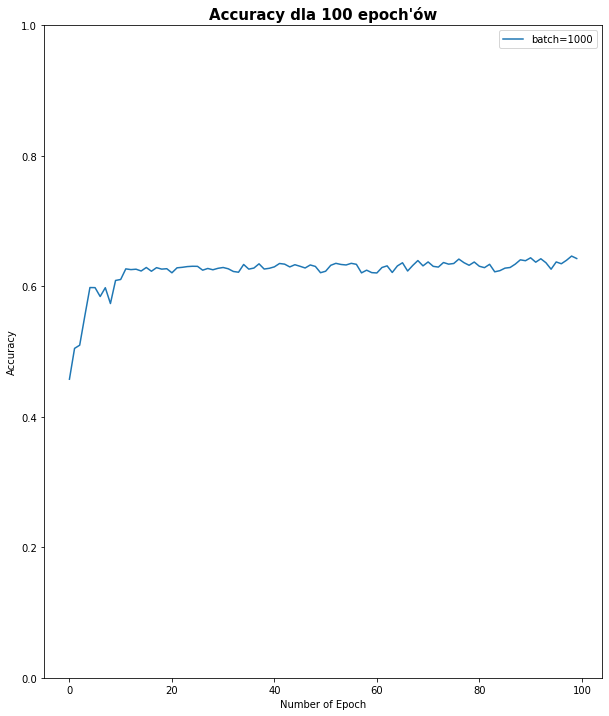

In [150]:
plt.figure(figsize=(10, 12))
plt.title("Accuracy dla 100 epoch'ów", fontdict={"fontweight": "bold", "size": 15})
plt.ylabel("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylim(0, 1)
plt.plot(batch1000.history['categorical_accuracy'], label="batch=1000")
plt.legend()

Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Funkcja straty: https://www.brutalk.com/pl/wiadomosci/brutalk-blog/przeglad/funkcje-strat-i-strat-do-szkolenia-sieci-neuronowych-uczenia-glebokiego-6046fa42120e8

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

### model evaluation

In [152]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7525 - categorical_accuracy: 0.6240


[0.7524932622909546, 0.6240000128746033]

## Próba przewidzenie czy wygra biały
